Note: you may need to restart the kernel to use updated packages.


/home/lerato/phishing-risk-detection-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


New label distribution: label
0    353795
1     53657
Name: count, dtype: int64
Label distribution in full dataset:
label
0    353795
1     53657
Name: count, dtype: int64
Label distribution in test set:
label
0    106139
1     16097
Name: count, dtype: int64
Label distribution in test set:
label
0    106139
1     16097
Name: count, dtype: int64
Model saved to ../models/phishing_rf_model.pkl
Model saved to ../models/phishing_rf_model.pkl
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    106139
           1       0.04      0.00      0.00     16097

    accuracy                           0.87    122236
   macro avg       0.45      0.50      0.46    122236
weighted avg       0.76      0.87      0.81    122236

              precision    recall  f1-score   support

           0       0.87      1.00      0.93    106139
           1       0.04      0.00      0.00     16097

    accuracy                           0.87    122236
   macro avg 

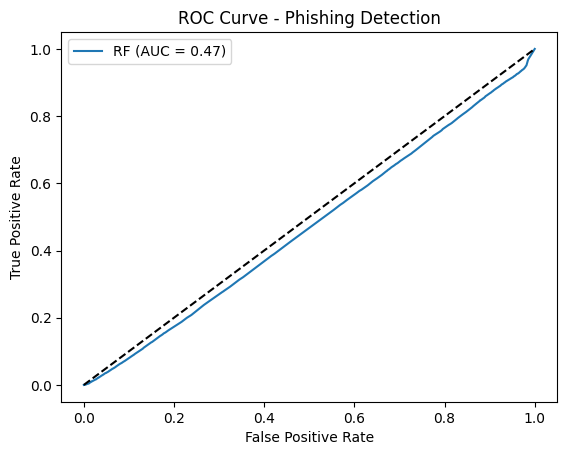

In [ ]:
# 04-model-training.ipynb
# Model Training & SHAP Explainability

"""
## 04 - Model Training and Explainability

This notebook:
1. Loads `phishing_graph_features.csv` with all features & labels.
2. Splits into train/test.
3. Trains a RandomForestClassifier for phishing detection.
4. Evaluates performance (accuracy, precision, recall, F1, ROC-AUC).
5. Uses SHAP to generate global and local explanations.
6. Saves model and explanation visuals.
"""

#%%
# 1. Imports and Config
%pip install joblib shap --quiet

import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import shap
import numpy as np

# Paths
FEATURE_CSV = os.path.join('..','data','processed','phishing_graph_features.csv')
MODEL_PATH = os.path.join('..','models','phishing_rf_model.pkl')
SHAP_SUMMARY_PLOT = os.path.join('..','models','phishing_shap_summary.png')

#%%
# 2. Load Data and Augment with Synthetic Negatives

# Load your phishing data
df = pd.read_csv(FEATURE_CSV)

# Create synthetic legitimate samples (same columns, label=0)
n_neg = len(df) // 2  # e.g., half as many negatives as positives
negatives = df.sample(n=n_neg, replace=True).copy()
negatives['label'] = 0
# Optionally, randomize some features to make them less "phishy"
negatives['graph_pagerank'] = negatives['graph_pagerank'].sample(frac=1).values

# Combine and shuffle
df_full = pd.concat([df, negatives], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_full.to_csv(FEATURE_CSV, index=False)
print("New label distribution:", df_full['label'].value_counts())

print("Label distribution in full dataset:")
print(df_full['label'].value_counts())  # <--- NEW: See if you have both classes

X = df_full.drop(columns=['label','url','sender_domain','domain'])  # drop non-numeric
y = df_full['label']

#%%
# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("Label distribution in test set:")
print(pd.Series(y_test).value_counts())  # <--- NEW: See if both classes are in test

#%%
# 4. Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
joblib.dump(clf, MODEL_PATH)
print("Model saved to", MODEL_PATH)

#%%
# 5. Evaluate Performance
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Only compute ROC AUC and SHAP if both classes are present in y_test
if np.unique(y_test).size > 1:
    # ROC AUC
    scores = None
    if hasattr(clf, 'predict_proba'):
        proba = clf.predict_proba(X_test)
        if getattr(proba, 'ndim', 0) == 2 and proba.shape[1] > 1:
            scores = proba[:, 1]
        else:
            scores = proba.ravel()
    elif hasattr(clf, 'decision_function'):
        scores = clf.decision_function(X_test)
    else:
        scores = clf.predict(X_test)
    try:
        roc_auc = roc_auc_score(y_test, scores)
        fpr, tpr, _ = roc_curve(y_test, scores)
        print(f"ROC AUC: {roc_auc:.3f}")

        plt.figure()
        plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Phishing Detection')
        plt.legend()
        plt.show()
    except Exception as e:
        print('Could not compute ROC AUC:', e)

    # SHAP Explainability
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)

    # Pick the "positive" class explanation when available and ensure shapes align
    sv_for_pos_class = None
    ev_for_pos_class = None

    # Convert to numpy array for robust handling
    sv_arr = np.array(shap_values)
    n_samples, n_features = X_test.shape

    if isinstance(shap_values, list):
        # shap returns a list of arrays, one per class: each should be (n_samples, n_features)
        if len(shap_values) > 1:
            sv_for_pos_class = np.array(shap_values[1])
        else:
            sv_for_pos_class = np.array(shap_values[0])
    else:
        # shap returned a single ndarray; common layout is (n_samples, n_features, n_classes)
        if sv_arr.ndim == 3:
            # common case: (n_samples, n_features, n_classes)
            if sv_arr.shape[0] == n_samples and sv_arr.shape[1] == n_features:
                pos_idx = 1 if sv_arr.shape[2] > 1 else 0
                sv_for_pos_class = sv_arr[:, :, pos_idx]
            # alternate common case: (n_classes, n_samples, n_features)
            elif sv_arr.shape[0] > 1 and sv_arr.shape[1] == n_samples and sv_arr.shape[2] == n_features:
                pos_idx = 1 if sv_arr.shape[0] > 1 else 0
                sv_for_pos_class = sv_arr[pos_idx, :, :]
            else:
                # try to infer axes by matching sample/feature counts and transpose accordingly
                axes = sv_arr.shape
                try:
                    sample_axis = next(i for i,s in enumerate(axes) if s == n_samples)
                    feature_axis = next(i for i,s in enumerate(axes) if s == n_features)
                    class_axis = [0,1,2]
                    class_axis.remove(sample_axis); class_axis.remove(feature_axis)
                    perm = (sample_axis, feature_axis, class_axis[0])
                    sv_perm = sv_arr.transpose(perm)
                    pos_idx = 1 if sv_perm.shape[2] > 1 else 0
                    sv_for_pos_class = sv_perm[:, :, pos_idx]
                except StopIteration:
                    # fall back to a safe reshape if possible
                    sv_for_pos_class = sv_arr.reshape(n_samples, -1)[:, :n_features]
        elif sv_arr.ndim == 2:
            # already (n_samples, n_features)
            sv_for_pos_class = sv_arr
        else:
            # attempt to reshape to (n_samples, n_features)
            sv_for_pos_class = sv_arr.reshape(n_samples, -1)[:, :n_features]

    # Ensure final shape is (n_samples, n_features)
    sv_for_pos_class = np.array(sv_for_pos_class)
    if sv_for_pos_class.shape != (n_samples, n_features):
        # try transpose if it accidentally got (n_features, n_samples)
        if sv_for_pos_class.shape == (n_features, n_samples):
            sv_for_pos_class = sv_for_pos_class.T
        else:
            raise AssertionError(f"The shape of the shap_values matrix ({sv_for_pos_class.shape}) does not match the shape of the provided data matrix ({(n_samples, n_features)}).")

    # Expected value for positive class (if multiclass)
    ev = explainer.expected_value
    if hasattr(ev, "__len__"):
        try:
            ev_for_pos_class = ev[1] if len(ev) > 1 else ev[0]
        except Exception:
            ev_for_pos_class = ev
    else:
        ev_for_pos_class = ev

    # Global summary plot
    # Sample 500 rows for SHAP summary plot to avoid long runtimes
    X_shap = X_test.sample(n=500, random_state=42) if len(X_test) > 500 else X_test
    sv_shap = sv_for_pos_class[X_shap.index]
    shap.summary_plot(sv_shap, X_shap, show=False)
    plt.savefig(SHAP_SUMMARY_PLOT, bbox_inches='tight')
    print("SHAP summary plot saved to", SHAP_SUMMARY_PLOT)

    # Local Explanation Example
    i = 0  # positional index of test instance (0..n-1)
    data_row = X_test.iloc[[i]]

    if hasattr(ev_for_pos_class, "__len__"):
        try:
            ev_scalar = float(ev_for_pos_class) if np.size(ev_for_pos_class) == 1 else ev_for_pos_class
        except Exception:
            ev_scalar = ev_for_pos_class
    else:
        ev_scalar = ev_for_pos_class

    sv_instance = sv_for_pos_class[i]
    shap.force_plot(ev_scalar, sv_instance, data_row, matplotlib=True)
    plt.show()

else:
    print('Only one class present in y_test; skipping ROC AUC, ROC curve, and SHAP plots (need both classes).')